In [ ]:
import qsample as qs
import qiskit
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm
import pymatching

/Users/jhfontes/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
basic = stim.Circuit("""
R 0 1
X_ERROR(0.01) 0 1
CNOT 0 1
X_ERROR(0.01) 0 1
M 0 1
DETECTOR rec[-2] 
DETECTOR rec[-1]
OBSERVABLE_INCLUDE(0) rec[-1] rec[-2]
""")

dem = basic.detector_error_model()
print(repr(dem))

matcher = pymatching.Matching.from_detector_error_model(dem)
matcher.decode([0,1])

stim.DetectorErrorModel('''
    error(0.01) D0 D1
    error(0.01) D0 L0
    error(0.0198) D1 L0
''')


array([1], dtype=uint8)

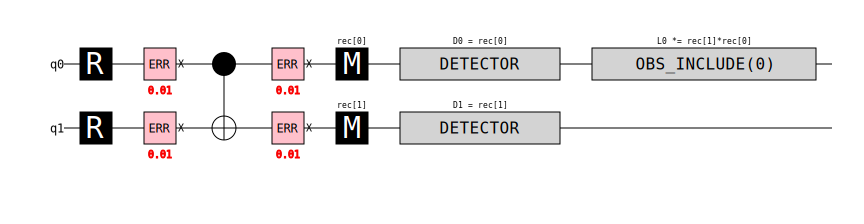

In [ ]:
basic.diagram('timeline-svg')

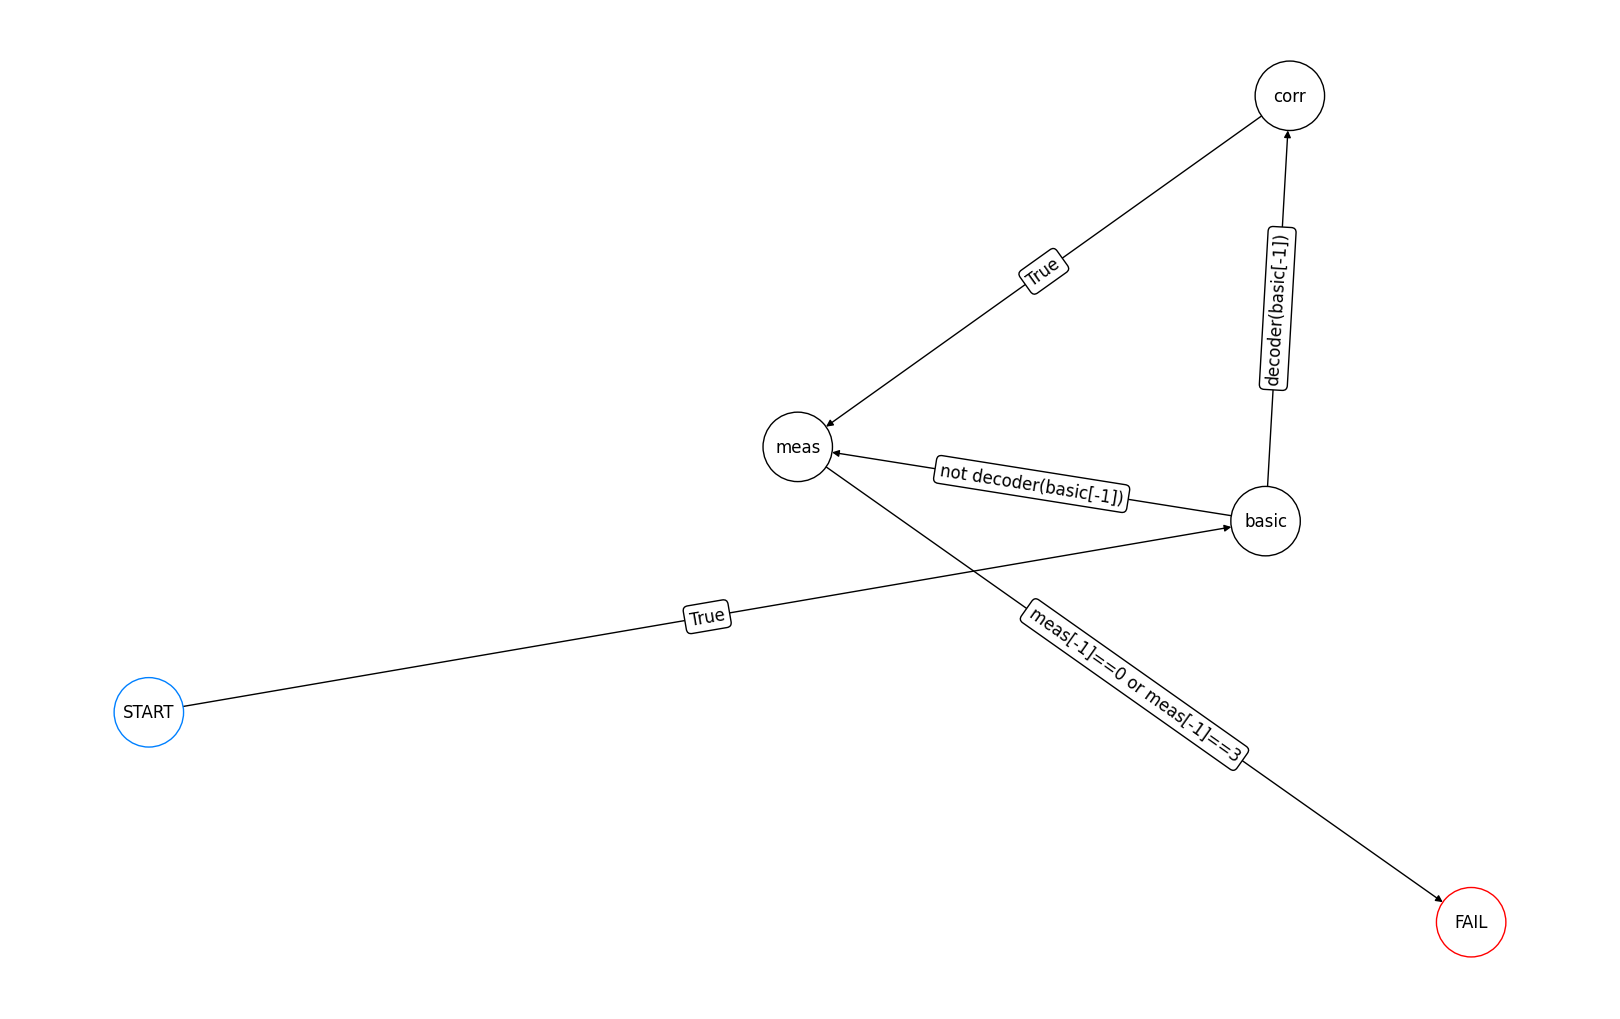

In [ ]:
basic = qs.Circuit(noisy=True).from_stim_circuit("""
R 0 1
X_ERROR(0.01) 0 1
CNOT 0 1
X_ERROR(0.01) 0 1
M 0 1
DETECTOR rec[-2] 
DETECTOR rec[-1]
OBSERVABLE_INCLUDE(0) rec[-1] rec[-2]
""")

corr = qs.Circuit(noisy=False).from_stim_circuit("""X 0""")
meas = qs.Circuit(noisy=False).from_stim_circuit("""M 0 1""")

    
def decoder(out):
    result = matcher.decode([out//2, out%2])
    return result

functions = {'decoder': decoder}
protocol = qs.Protocol(check_functions=functions)


n_rounds = 4
protocol.add_nodes_from(['basic', 'corr', 'meas'], circuits=[basic, corr, meas])
protocol.add_edge('START', 'basic', check='True')
protocol.add_edge('basic', 'corr', check='decoder(basic[-1])')
protocol.add_edge('basic', 'meas', check='not decoder(basic[-1])')
protocol.add_edge('corr', 'meas', check='True')
protocol.add_edge('meas', 'FAIL', check='meas[-1]==0 or meas[-1]==3')

protocol.draw(figsize=(16,10))

p=('1.00e-02',): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 962.39it/s]


time: 0.1264810562133789 s


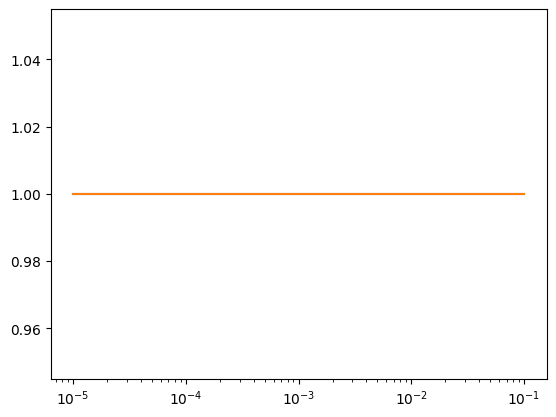

In [ ]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
err_params = {'q': q}

begin = time.time()
ss_sam = qs.SubsetSampler(protocol=protocol, simulator=qs.StimSimulator,  p_max={'q': 0.01}, err_model=err_model, err_params=err_params, L=2)
ss_sam.run(100)
end = time.time()
qsample_time = end-begin

v1 = ss_sam.stats()[0]
w1 = ss_sam.stats()[2]

plt.plot(q, v1)
plt.plot(q, w1)
plt.xscale('log')
print('time:', qsample_time, 's')